In [93]:
from textblob import TextBlob

import pandas as pd
import numpy as np
import nltk
import os

import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from helper import *

In [19]:
data = pd.read_csv('Data/PRAW-Data.csv')
data_dum = data.copy()

In [20]:
data_dum.head(5)

,Post ID,Title,URL,Body,Score,Comments,Comments Count,Time Stamp,Flair
0,g014wc,"Lost my Job, Sick Mother and Paralysed Dad, In...",https://www.reddit.com/r/india/comments/g014wc...,Hi....It's really tough time for everyone. I r...,1048,I'm a freelancer. Don't listen to the idiots ...,131,1.586713e+09,AskIndia
1,fxofyu,Why does the government come with a begging bo...,https://www.reddit.com/r/india/comments/fxofyu...,"We have floods, terrorist attacks, famines due...",646,I don't understand why they don't use money f...,204,1.586419e+09,AskIndia
2,g0zlly,Mother's condition is going worse due to hepat...,https://www.reddit.com/r/india/comments/g0zlly...,"Hi folks, I really appreciate the warm respons...",763,If anyone knows who is influential on Twitter...,94,1.586842e+09,AskIndia
3,fvy95j,Men who are 30+ and have decided not to get ma...,https://www.reddit.com/r/india/comments/fvy95j...,The corona virus has given me some time to thi...,266,Plan your finances. Work and enjoy in your ow...,206,1.586178e+09,AskIndia
4,g1lmhg,[Please Advice] Reality punched me in the face...,https://www.reddit.com/r/india/comments/g1lmhg...,"Sorry Reddit, this post is going to be long. P...",430,One thing I will say is don't try to clear of...,83,1.586928e+09,AskIndia


In [21]:
count = data_dum.shape[0]
print('Number of Examples in data set: {}. Number of Target Variables: {}.'.format(data_dum.shape[0], len(data_dum.Flair.unique())))

Number of Examples in data set: 2656. Number of Target Variables: 11.


### Filled NaN values

In [22]:
data_dum.isna().sum()

Post ID              0
Title                0
URL                  0
Body              1730
Score                0
Comments           235
Comments Count       0
Time Stamp           0
Flair                0
dtype: int64

In [23]:
data_dum["Body"].fillna(" ", inplace = True) 
data_dum["Comments"].fillna(" ", inplace = True)

In [24]:
title = data_dum['Title'].values
url = data_dum['URL'].values
comms = data_dum['Comments'].values
body = data_dum['Body'].values

### Basic text preprocessing

In [26]:
for ind in range(count):
        
    title[ind] = preprocessing(title[ind])
    url[ind] = url[ind].split('/')[2]
    comms[ind] = preprocessing(comms[ind])
    body[ind] = preprocessing(body[ind])

### Removed stop words and non-english words

In [27]:
for ind in range(count):
        
    title[ind] = remstopwords(title[ind])
    comms[ind] = remstopwords(comms[ind])
    body[ind] = remstopwords(body[ind])

### Lemmatization

In [32]:
for ind in range(count):
        
    title[ind] = lemmatize(title[ind])
    comms[ind] = lemmatize(comms[ind])
    body[ind] = lemmatize(body[ind])

### Checked the count of non-english entities, if any

In [101]:
print("Number of Titles in English - " + str(data_dum["Title"].apply(isEnglish).sum()))
print("Number of Comments in English - " + str(data_dum["Comments"].apply(isEnglish).sum()))
print("Number of Bodies in English - " + str(data_dum["Body"].apply(isEnglish).sum()))

Number of Titles in English - 2656
Number of Comments in English - 2656
Number of Bodies in English - 2656


### Some stats after preprocessing

In [36]:
print('Average word length of Titles in Data set is {0:.0f}.'.format(np.mean(data_dum['Title'].apply(lambda x: len(x.split())))))

Average word length of Titles in Data set is 5.


In [99]:
print('Number of Examples per target variable!', Counter(data_dum.Flair))

Number of Examples per target variable! Counter({'Coronavirus': 249, 'Politics': 249, 'Scheduled': 246, 'Science/Technology': 245, 'Policy/Economy': 245, 'Non-Political': 244, 'Business/Finance': 243, 'Food': 242, 'Photography': 241, 'AskIndia': 235, 'Sports': 217})


In [44]:
data_dum.describe()[["Score", "Comments Count"]]

,Score,Comments Count
count,2656.00000,2656.000000
mean,281.15512,146.146461
std,753.56066,395.062786
min,0.00000,0.000000
25%,17.00000,5.000000
50%,49.00000,20.000000
75%,203.00000,63.000000
max,17878.00000,4194.000000


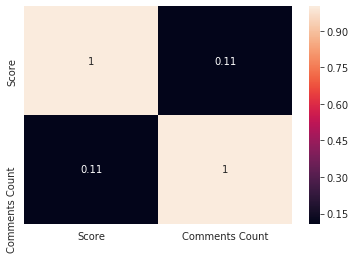

In [45]:
feature_df = data_dum[["Score", "Comments Count"]]

feature_corrMatrix = feature_df.corr()

sns.heatmap(feature_corrMatrix, annot=True)
plt.show()

In [47]:
data_dum = data_dum.drop(['Time Stamp'], axis = 1)

### Added a Combined feature!

Here, a combined feature is added, which is a concatenation of Title, Body and Comments for each example.
Further, each example's combined feature is augmented, to make another example which contains the same sentences but in a shuffled manner, and each word in the augmented example is exchanged with its synonym if any.

This is done to increase the number of examples, in order to avoid overfitting.

In [48]:
from nltk import sent_tokenize
from nltk.corpus import wordnet

In [49]:
def combineFeature(feature1, feature2, feature3):
    
    X1 = data_dum[feature1].values.astype("str")
    X2 = data_dum[feature2].values.astype("str")
    X3 = data_dum[feature3].values.astype("str")
    Y = data_dum.Flair.values
    
    X = []
    F = []
    for ind in range(count):
        
        X.append(X1[ind] + ' ' + X2[ind] + ' ' + X3[ind])
        F.append(Y[ind])
          
    return X, F

In [50]:
combfeature, fla = combineFeature("Title", "Comments", "Body")
exCount = len(combfeature)

In [51]:
alph = [' a ',' b ',' c ',' d ',' e ',' f ',' g ',' h ',' i ',' j ',' k ',' l ',' m ',' n ',' o ',' p ', ' q ',
        ' r ',' s ',' t ',' u ',' v ',' w ',' x ',' y ',' z ']

In [52]:
for count in range(exCount):
    
    ft = sent_tokenize(combfeature[count])
    np.random.shuffle(ft)
    
    combfeature[count] = combfeature[count].replace(" .", "")
    
    ft_flair = str(fla[count])
    
    newOrder = []
    
    for ind1 in range(len(ft)):
        ft[ind1] = ft[ind1].replace(".", "")
        ft[ind1] = ft[ind1].strip()

        newSent = []

        lst = ft[ind1].split()

        for char in lst:
            if char in alph:
                lst.replace(char, "")

        for ind2 in range(len(lst)):

            try:

                syns = wordnet.synsets(lst[ind2])
                newSent.append(syns[0].lemmas()[0].name())
                newString = " ".join(word for word in newSent)

            except IndexError:

                newSent.append(lst[ind2])

        newOrder.append(newString)

        newPara = ' '.join(sent for sent in newOrder)
    
    combfeature.append(newPara)
    fla.append(ft_flair)
    
    print("Done - "+str(count))

Done - 0
Done - 1
Done - 2
Done - 3
Done - 4
Done - 5
Done - 6
Done - 7
Done - 8
Done - 9
Done - 10
Done - 11
Done - 12
Done - 13
Done - 14
Done - 15
Done - 16
Done - 17
Done - 18
Done - 19
Done - 20
Done - 21
Done - 22
Done - 23
Done - 24
Done - 25
Done - 26
Done - 27
Done - 28
Done - 29
Done - 30
Done - 31
Done - 32
Done - 33
Done - 34
Done - 35
Done - 36
Done - 37
Done - 38
Done - 39
Done - 40
Done - 41
Done - 42
Done - 43
Done - 44
Done - 45
Done - 46
Done - 47
Done - 48
Done - 49
Done - 50
Done - 51
Done - 52
Done - 53
Done - 54
Done - 55
Done - 56
Done - 57
Done - 58
Done - 59
Done - 60
Done - 61
Done - 62
Done - 63
Done - 64
Done - 65
Done - 66
Done - 67
Done - 68
Done - 69
Done - 70
Done - 71
Done - 72
Done - 73
Done - 74
Done - 75
Done - 76
Done - 77
Done - 78
Done - 79
Done - 80
Done - 81
Done - 82
Done - 83
Done - 84
Done - 85
Done - 86
Done - 87
Done - 88
Done - 89
Done - 90
Done - 91
Done - 92
Done - 93
Done - 94
Done - 95
Done - 96
Done - 97
Done - 98
Done - 99
Done - 100

Done - 793
Done - 794
Done - 795
Done - 796
Done - 797
Done - 798
Done - 799
Done - 800
Done - 801
Done - 802
Done - 803
Done - 804
Done - 805
Done - 806
Done - 807
Done - 808
Done - 809
Done - 810
Done - 811
Done - 812
Done - 813
Done - 814
Done - 815
Done - 816
Done - 817
Done - 818
Done - 819
Done - 820
Done - 821
Done - 822
Done - 823
Done - 824
Done - 825
Done - 826
Done - 827
Done - 828
Done - 829
Done - 830
Done - 831
Done - 832
Done - 833
Done - 834
Done - 835
Done - 836
Done - 837
Done - 838
Done - 839
Done - 840
Done - 841
Done - 842
Done - 843
Done - 844
Done - 845
Done - 846
Done - 847
Done - 848
Done - 849
Done - 850
Done - 851
Done - 852
Done - 853
Done - 854
Done - 855
Done - 856
Done - 857
Done - 858
Done - 859
Done - 860
Done - 861
Done - 862
Done - 863
Done - 864
Done - 865
Done - 866
Done - 867
Done - 868
Done - 869
Done - 870
Done - 871
Done - 872
Done - 873
Done - 874
Done - 875
Done - 876
Done - 877
Done - 878
Done - 879
Done - 880
Done - 881
Done - 882
Done - 883

Done - 1519
Done - 1520
Done - 1521
Done - 1522
Done - 1523
Done - 1524
Done - 1525
Done - 1526
Done - 1527
Done - 1528
Done - 1529
Done - 1530
Done - 1531
Done - 1532
Done - 1533
Done - 1534
Done - 1535
Done - 1536
Done - 1537
Done - 1538
Done - 1539
Done - 1540
Done - 1541
Done - 1542
Done - 1543
Done - 1544
Done - 1545
Done - 1546
Done - 1547
Done - 1548
Done - 1549
Done - 1550
Done - 1551
Done - 1552
Done - 1553
Done - 1554
Done - 1555
Done - 1556
Done - 1557
Done - 1558
Done - 1559
Done - 1560
Done - 1561
Done - 1562
Done - 1563
Done - 1564
Done - 1565
Done - 1566
Done - 1567
Done - 1568
Done - 1569
Done - 1570
Done - 1571
Done - 1572
Done - 1573
Done - 1574
Done - 1575
Done - 1576
Done - 1577
Done - 1578
Done - 1579
Done - 1580
Done - 1581
Done - 1582
Done - 1583
Done - 1584
Done - 1585
Done - 1586
Done - 1587
Done - 1588
Done - 1589
Done - 1590
Done - 1591
Done - 1592
Done - 1593
Done - 1594
Done - 1595
Done - 1596
Done - 1597
Done - 1598
Done - 1599
Done - 1600
Done - 1601
Done

Done - 2204
Done - 2205
Done - 2206
Done - 2207
Done - 2208
Done - 2209
Done - 2210
Done - 2211
Done - 2212
Done - 2213
Done - 2214
Done - 2215
Done - 2216
Done - 2217
Done - 2218
Done - 2219
Done - 2220
Done - 2221
Done - 2222
Done - 2223
Done - 2224
Done - 2225
Done - 2226
Done - 2227
Done - 2228
Done - 2229
Done - 2230
Done - 2231
Done - 2232
Done - 2233
Done - 2234
Done - 2235
Done - 2236
Done - 2237
Done - 2238
Done - 2239
Done - 2240
Done - 2241
Done - 2242
Done - 2243
Done - 2244
Done - 2245
Done - 2246
Done - 2247
Done - 2248
Done - 2249
Done - 2250
Done - 2251
Done - 2252
Done - 2253
Done - 2254
Done - 2255
Done - 2256
Done - 2257
Done - 2258
Done - 2259
Done - 2260
Done - 2261
Done - 2262
Done - 2263
Done - 2264
Done - 2265
Done - 2266
Done - 2267
Done - 2268
Done - 2269
Done - 2270
Done - 2271
Done - 2272
Done - 2273
Done - 2274
Done - 2275
Done - 2276
Done - 2277
Done - 2278
Done - 2279
Done - 2280
Done - 2281
Done - 2282
Done - 2283
Done - 2284
Done - 2285
Done - 2286
Done

Original Combined-Feature Example at index 0 

In [86]:
print(str(combfeature[0]) + " - " + str(fla[0]))

lost job sick mother dad earn listen beginner hard fact one trust job know talking area contact one one definitely one able help also look call local municipality corporation talk waiting help also start crisis time correct time lean around look opportunity weather slowly start looking magical way make money expert anyone otherwise idiot listen luck take care get remind often maybe add post someone could help hey work video editor academy channel currently looking video visibility sorry hope get soon helpful also mention maybe something like add profile see send video work way everyone vote help fellow mention skill set hey hey please write post network capital sure many people come forward help additional reach working locally area like someone said try fill gap supply chain sure working right would get money going volunteer work however try write society explaining situation see give work remotely best really hope something work reach need help food would happy help also run really h

Augmented Combined-Feature Example at index 2656 of Original Combined-Feature Example at index 0

In [87]:
print(str(combfeature[2656]) + " - " + str(fla[2656]))

hello truly street_fighter time see send video work manner promise anything Lashkar-e-Taiba talk figure presently look video departure volunteer work best truly hope something work possibly attention_deficit_disorder post person could aid call local municipality corporation talk get remind frequently check relevant company mention hey work video editor academy channel attention_deficit_disorder profile please propose consequently correct time tilt about lever patient know talk area contact one one know talk area contact one one send sketch would happy aid besides run truly difficult discovery employment right certain able aid manner recently doomed occupation novice listen money salvage already spend mother treatment difficult fact doomed occupation sick mother dad gain Tell gain money money actually right propose manner get besides start crisis time however attempt write society explain situation see give work remotely thanks reading technology alumnus experience design content writin

In [98]:
print("Number of total examples after augmentation - " + str(len(combfeature)))

Number of total examples after augmentation - 5312


In [58]:
CombFeature_df = pd.DataFrame()
CombFeature_df["CombinedFeature"] = combfeature
CombFeature_df["Flair"] = fla

In [59]:
CombFeature_df.head(5)

,CombinedFeature,Flair
0,lost job sick mother dad earn listen beginner ...,AskIndia
1,government come begging bowl every crisis unde...,AskIndia
2,mother condition going worse due hepatitis b e...,AskIndia
3,men decided get married plan old age plan work...,AskIndia
4,please advice reality face today one thing say...,AskIndia


In [60]:
CombFeature_df.to_csv("Data/PRAW-CombinedFeature.csv", index = False)

In [88]:
def rempunctuation(ent):

    ent = str(ent)

    ent = ent.lower()
    punctuations = '''!()-[]{};:'."\,<>/?@#$%^&*_~'''
    
    for char in ent:
        if char in punctuations:
            ent = ent.replace(char, " ")
            
    sents = ent.split("   ")
    ent = " ".join(sent for sent in sents)
    
    ent = ent.strip()

    return ent

In [89]:
for ind in range(count):
        
    title[ind] = rempunctuation(title[ind])
    comms[ind] = rempunctuation(comms[ind])
    body[ind] = rempunctuation(body[ind])

### Normalized Integer features

Normalized numerical features in data_dum

In [95]:
normalize("Score")
normalize("Comments Count")

In [96]:
data_dum.to_csv("Data/PRAW-Preprocessed.csv", index = False)

In [97]:
data_dum.iloc[679]

Post ID                                                      g32037
Title                            set import second hand covid shoot
URL                                          www.businessinsider.in
Body                                                               
Score                                                   0.000894955
Comments          people ventilator second hand ventilator may n...
Comments Count                                          0.000238436
Flair                                                   Coronavirus
Name: 679, dtype: object